In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("my_data/clustered_data.csv")
df

,x,y,z,groove,tread,depth
0,0.15000,-0.12917,0.42000,-1,True,2.252963
1,0.15000,-0.12917,0.42000,-1,True,2.252963
2,0.14988,-0.12882,0.42000,-1,True,2.539181
3,0.14988,-0.12882,0.42000,-1,True,2.539181
4,0.14882,-0.13181,0.41882,-1,True,1.286047
...,...,...,...,...,...,...
195176,-0.13118,0.02294,0.27167,2,False,3.290156
195177,-0.13118,0.02287,0.27176,2,False,3.393917
195178,-0.13000,0.02287,0.27176,2,False,3.116971
195179,-0.12412,0.02271,0.27176,2,False,3.018646


## Filter groove bottom

In [3]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def func(x, a, b, c, d):
    # Get x and y axis
    return a*x**3 + b*x**2 + c*x + d

# Filter dataframe
df["bottom"] = False

# Iterate grooves
grooves = df.query("groove != -1").groove.unique()
for g in grooves:
    
    # Subdivide the z axis
    groove_df = df.query(f"groove == {g}")
    x_height, x_edges = np.histogram(groove_df.x, bins=100)
    x_edges = [(x_edges[i], x_edges[i+1]) for i in range(x_height.shape[0])]
    
    for l, u in x_edges:
        # Filter dataframe in that area
        slice_df = df.query(f"groove == {g} and x >= {l} and x <= {u}")
        
        # Curve fit
        params, _ = curve_fit(func, slice_df.y, slice_df.z)
        a, b, c, d = params[0], params[1], params[2], params[3]
        
        # Create curve data
        y = np.linspace(slice_df.y.min(), slice_df.y.max(), 100)
        z = func(y, a, b, c, d)
        
        # Find curve maximum
        peaks, _ = find_peaks(z)
        peaks_y = y[peaks]
        peaks_z = z[peaks]
        
        # Region of acceptance
        peaks_min_z = (peaks_z[0] - 0.002) * np.ones(y.shape[0])
        peaks_max_z = (peaks_z[0] + 0.002) * np.ones(y.shape[0])
        
        # Get idx of accepted datapoints
        accepted_df = slice_df.query(f"z >= {peaks_min_z[0]} and z <= {peaks_max_z[0]}")
        idx = accepted_df.index
        df.loc[idx, "bottom"] = True

In [17]:
def func(df, a, b, r):
    # Get x and z axis
    x, z = df.x, df.z
    
    return 2*a*x + 2*b*z + r**2 - a**2 - b**2

# Parameters for curve fitting
# groove_df = df.query("groove != -1")
grooves = [g for g in df.groove.unique() if g != -1]
parameters = []

for groove in grooves:
    # Filter dataframe
    groove_df = df.query(f"groove == {groove} and bottom")
    
    # Get x and z components
    x, z = groove_df.x, groove_df.z

    # Curve fitting
    params, _ = curve_fit(func, groove_df, x**2 + z**2, xtol=1e-20)
    parameters.append(params)
   
# Calculate mean parameters 
parameters = np.mean(parameters, axis=0)
parameters

array([-0.11365942,  0.60463176, -0.32857832])

In [6]:
def func(df, a, b, r):
    # Get x and z axis
    x, z = df.x, df.z
    
    return 2*a*x + 2*b*z + r**2 - a**2 - b**2

# Parameters for curve fitting
# groove_df = df.query("groove != -1")
groove_df = df.query("bottom")
parameters = []

x, z = groove_df.x, groove_df.z

# Curve fitting
params, _ = curve_fit(func, groove_df, x**2 + z**2, xtol=1e-20)
params

array([-0.11252984,  0.60207558, -0.32587781])

In [18]:
import plotly.graph_objects as go

# Plot circle
angles = np.linspace(0, 2*np.pi, 1000)
circle_x = - params[2] * np.cos(angles) + params[0]
circle_z = - params[2] * np.sin(angles) + params[1]

data = [
    go.Scatter(x=circle_x, y=circle_z, mode="markers", marker=dict(size=2, color="red")),
    go.Scatter(x=groove_df.x, y=groove_df.z, mode="markers", marker=dict(size=2, color="green"))
]
fig = go.Figure(data)
fig.show()

In [19]:
c = np.array([params[0], params[1]])
r = np.abs(params[1])

<AxesSubplot: >

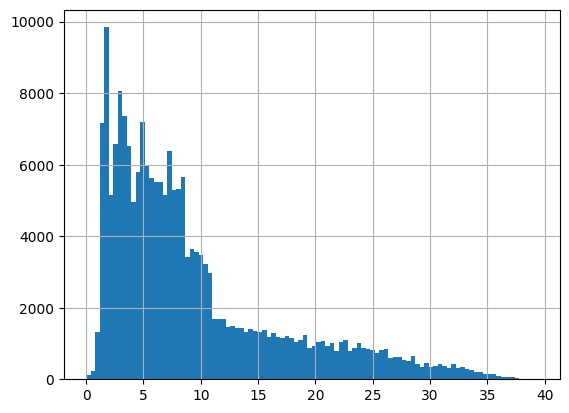

In [20]:
radius = np.sqrt((c[0] - df.x)**2 + (c[1] - df.z)**2)
depth = (radius.max() - radius) * 1000
depth.hist(bins=100)

In [21]:
df["my_depth"] = depth

<AxesSubplot: >

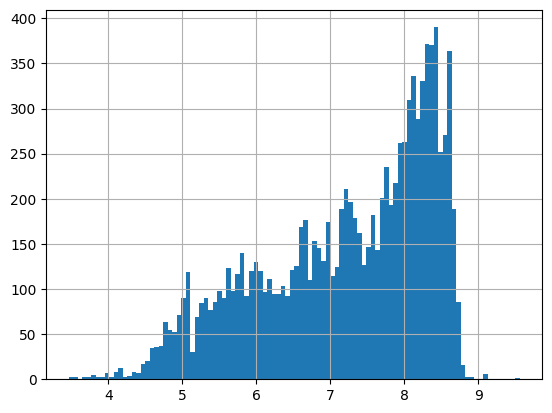

In [22]:
df.query("groove == 1").my_depth.hist(bins=100)

<AxesSubplot: >

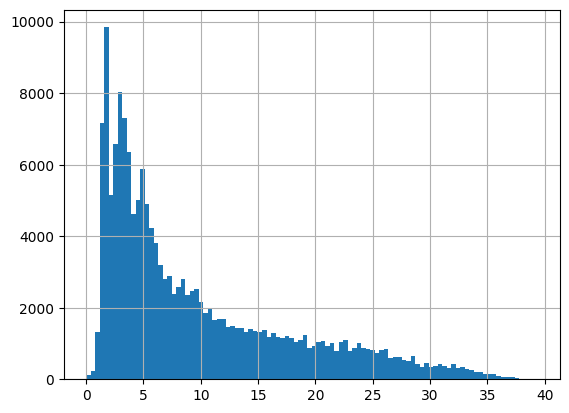

In [23]:
df.query("groove == -1").my_depth.hist(bins=100)

## Difference pdf estimation

In [24]:
from scipy.stats import gaussian_kde

# Get depth kde for each groove
groove_kdes = {}
for groove in df.groove.unique():
    
    # Filter dataset
    groove_df = df.query(f"groove == {groove}")
    
    # Compute and store kde
    kde = gaussian_kde(groove_df.my_depth)
    groove_kdes[groove] = kde
    
# Get surface kde separately
surface_kde = groove_kdes.pop(-1)

In [25]:
# Define random state for reproducibility
random_state = 42

# Define number of data points to sample for each kde
n_samples = 10000

# Sample from surface kde
surface_samples = surface_kde.resample(n_samples, random_state).reshape(-1)

# Sample each groove
groove_samples = {g: kde.resample(n_samples, random_state).reshape(-1) for g, kde in groove_kdes.items()}

# Get the sample difference per groove
groove_diff = {g: g_samples - surface_samples for g, g_samples in groove_samples.items()}

In [26]:
# Transform groove diff dict into dataframe
depth_diff_df = {
    "groove": np.concatenate([g*np.ones(s.shape[0], dtype="int64") for g, s in groove_diff.items()]),
    "diff": np.concatenate([s for s in groove_diff.values()])
}
depth_diff_df = pd.DataFrame(depth_diff_df)
depth_diff_df

,groove,diff
0,0,-14.427754
1,0,8.027970
2,0,-11.956446
3,0,3.656619
4,0,7.352956
...,...,...
29995,2,-7.336746
29996,2,5.156333
29997,2,4.752056
29998,2,-0.509209


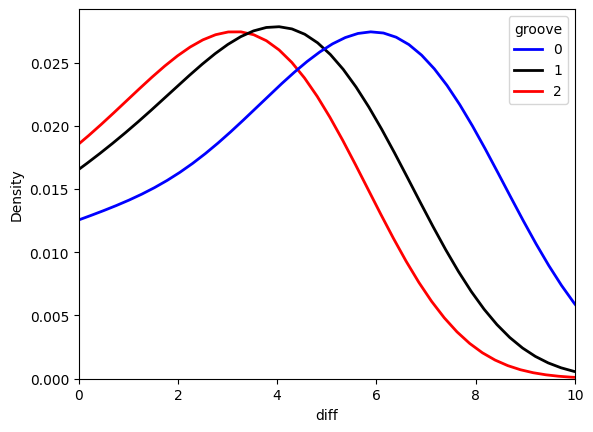

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = {0: "blue", 1: "black", 2: "red"}
sns.kdeplot(data=depth_diff_df, x="diff", hue="groove", palette=palette, linewidth=2)
plt.xlim(0, 10)
plt.show()